## Capstone 8
### Movie Recommendation

In [1]:
#Import Statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [2]:
# Loading movie data
df_movies = pd.read_csv('movies.txt')

#Loading ratings data
df_ratings = pd.read_csv('ratings.txt')

#### TASK EDA

In [3]:
#Display movie data
print(df_movies.head())
#Display ratings data
print(df_ratings.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [4]:
#Display information of Movies
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [5]:
#Display information of ratings
df_ratings.info()
df_ratings.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [6]:
print(df_movies.isna().sum())
print(df_ratings.isna().sum())
print(df_movies.isnull().sum())
print(df_ratings.isnull().sum())

movieId    0
title      0
genres     0
dtype: int64
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
movieId    0
title      0
genres     0
dtype: int64
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


#### TASK 2: Data Wrangling and Feature Engineering

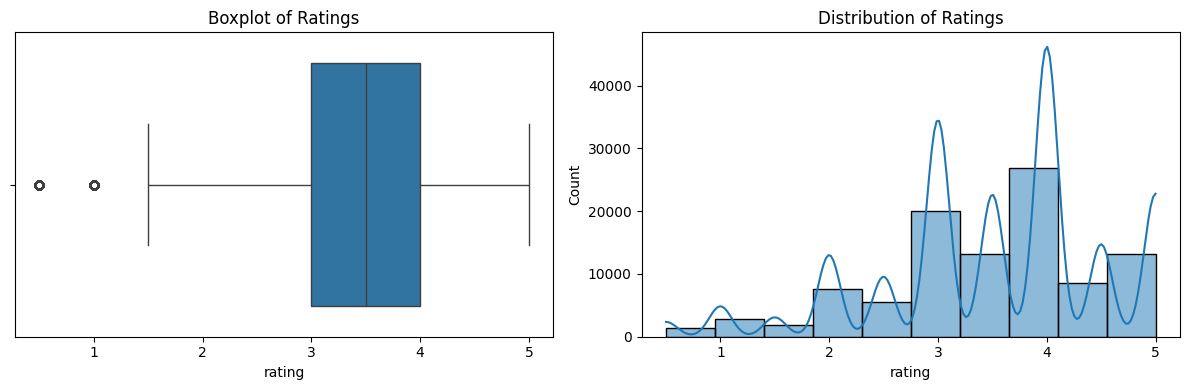

In [7]:
plt.figure(figsize=(12, 4))

# Boxplot for rating
plt.subplot(1, 2, 1)
sns.boxplot(x=df_ratings['rating'])
plt.title('Boxplot of Ratings')

# Histogram
plt.subplot(1, 2, 2)
sns.histplot(df_ratings['rating'], bins=10, kde=True)
plt.title('Distribution of Ratings')

plt.tight_layout()
plt.show()

In [8]:
merged_df = pd.merge(df_movies,df_ratings,on="movieId", how="inner")
merged_df.head
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    100836 non-null  int64  
 1   title      100836 non-null  object 
 2   genres     100836 non-null  object 
 3   userId     100836 non-null  int64  
 4   rating     100836 non-null  float64
 5   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 4.6+ MB


In [9]:
ui_matrix_df = merged_df[["userId","movieId","rating"]]
ui_matrix_df = ui_matrix_df.sort_values(by="userId")
ui_matrix_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100836 entries, 39640 to 55481
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 3.1 MB


In [10]:
ui_matrix_df.to_csv("ui_matrix.csv", index=False)
ui_matrix_df.describe()

,userId,movieId,rating
count,100836.000000,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557
std,182.618491,35530.987199,1.042529
min,1.000000,1.000000,0.500000
25%,177.000000,1199.000000,3.000000
50%,325.000000,2991.000000,3.500000
75%,477.000000,8122.000000,4.000000
max,610.000000,193609.000000,5.000000


In [11]:
# Create Data Table of users versus movie ratings
data_table = ui_matrix_df.pivot_table(index="userId",columns="movieId",values="rating")

# Fill in any missing rating with 0
data_table.fillna(0.0,inplace=True)
print("Table Shape: ",data_table.shape)
data_table

Table Shape:  (610, 9724)


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Calculate similarities between movies
movie_sim = cosine_similarity(data_table.T)

movie_sim_df = pd.DataFrame(movie_sim,index=data_table.columns,columns=data_table.columns)

print("Item similarity: ",movie_sim_df.shape)
movie_sim_df.head(10)

Item similarity:  (9724, 9724)


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.410562,0.296917,0.035573,0.308762,0.376316,0.277491,0.131629,0.232586,0.395573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.410562,1.000000,0.282438,0.106415,0.287795,0.297009,0.228576,0.172498,0.044835,0.417693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.296917,0.282438,1.000000,0.092406,0.417802,0.284257,0.402831,0.313434,0.304840,0.242954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.035573,0.106415,0.092406,1.000000,0.188376,0.089685,0.275035,0.158022,0.000000,0.095598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5,0.308762,0.287795,0.417802,0.188376,1.000000,0.298969,0.474002,0.283523,0.335058,0.218061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
6,0.376316,0.297009,0.284257,0.089685,0.298969,1.000000,0.244105,0.147562,0.214088,0.386414,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
7,0.277491,0.228576,0.402831,0.275035,0.474002,0.244105,1.000000,0.273757,0.162000,0.238949,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
8,0.131629,0.172498,0.313434,0.158022,0.283523,0.147562,0.273757,1.000000,0.000000,0.189867,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
9,0.232586,0.044835,0.304840,0.000000,0.335058,0.214088,0.162000,0.000000,1.000000,0.048611,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [ ]:
# Create SVD model
svd_model = TruncatedSVD(n_components=50, random_state=315)

ratings_features = svd_model.fit_transform(data_table)

predictions = np.dot(ratings_features,svd_model.components_)

predictions_df = pd.DataFrame(predictions,index=data_table.index,columns=data_table.columns)

predictions_df.head(10)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,2.404708,0.627211,1.019425,-0.116813,-0.538120,2.384999,-0.888156,0.004388,0.170362,1.535660,...,-0.048066,-0.041199,-0.054932,-0.054932,-0.048066,-0.054932,-0.048066,-0.048066,-0.048066,-0.057138
2,0.324764,-0.044808,0.054189,0.013242,0.175530,-0.071153,0.067272,0.023837,0.047758,-0.147597,...,0.017540,0.015034,0.020045,0.020045,0.017540,0.020045,0.017540,0.017540,0.017540,0.027949
3,-0.037322,0.048378,0.071939,0.001541,-0.010882,0.111758,-0.008249,-0.002163,-0.000373,-0.048939,...,-0.002618,-0.002244,-0.002991,-0.002991,-0.002618,-0.002991,-0.002618,-0.002618,-0.002618,-0.000452
4,2.241480,-0.718433,-0.159108,0.072502,0.158302,0.309069,0.579509,0.044375,0.005696,0.143083,...,-0.008550,-0.007329,-0.009772,-0.009772,-0.008550,-0.009772,-0.008550,-0.008550,-0.008550,-0.021587
5,1.185919,0.807129,0.104482,0.112121,0.224850,0.567690,0.214991,0.131086,-0.096594,1.038539,...,-0.006029,-0.005168,-0.006890,-0.006890,-0.006029,-0.006890,-0.006029,-0.006029,-0.006029,-0.004015
6,4.740926,3.820326,3.237265,0.617772,3.427752,3.653573,3.661294,0.815129,1.264124,3.107723,...,0.008622,0.007390,0.009854,0.009854,0.008622,0.009854,0.008622,0.008622,0.008622,0.017785
7,1.856831,0.913141,-0.016455,-0.047039,0.081353,0.928216,0.029875,-0.100896,0.024929,1.442753,...,-0.009246,-0.007925,-0.010567,-0.010567,-0.009246,-0.010567,-0.009246,-0.009246,-0.009246,-0.012704
8,1.024235,1.201282,0.297213,0.122811,0.227076,0.315982,0.339090,0.094242,-0.166968,1.593244,...,-0.003296,-0.002825,-0.003767,-0.003767,-0.003296,-0.003767,-0.003296,-0.003296,-0.003296,-0.002271
9,0.174575,0.280954,0.082570,0.025645,0.064594,-0.203036,-0.010581,0.004202,-0.022690,0.048107,...,0.001835,0.001573,0.002097,0.002097,0.001835,0.002097,0.001835,0.001835,0.001835,-0.003224


In [ ]:

print(ratings_features.shape)
print(svd_model.components_.shape)


(610, 50)
(50, 9724)


In [ ]:
# Create NMF model
nmf_model = NMF(n_components=50,random_state=50)

nmf_features = nmf_model.fit_transform(data_table)

nmf_predictions = np.dot(nmf_features,nmf_model.components_)

nmf_predictions_df = pd.DataFrame(nmf_predictions,index=data_table.index,columns=data_table.columns)

nmf_predictions_df.head(10)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,3.198348,1.582587,0.957745,0.003705,0.275954,1.594733,0.133700,0.015116,0.217524,1.904595,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.244635,0.124130,0.000000,0.000000,0.046569,0.075618,0.003339,0.000000,0.000118,0.007465,...,0.007969,0.006831,0.009108,0.009108,0.007969,0.009108,0.007969,0.007969,0.007969,0.011990
3,0.069083,0.052005,0.075411,0.000000,0.000000,0.091385,0.019999,0.000225,0.005687,0.047653,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000029
4,2.195881,0.338662,0.211728,0.049135,0.259372,0.599241,0.292736,0.021024,0.111971,0.229524,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.946445,1.005444,0.312242,0.093537,0.374092,0.502165,0.405959,0.122767,0.102485,1.315322,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,5.214837,2.847465,2.741396,0.492926,2.999146,4.209305,3.367725,0.552968,1.685515,3.678467,...,0.000049,0.000042,0.000057,0.000057,0.000049,0.000057,0.000049,0.000049,0.000049,0.000026
7,1.844437,0.507069,0.075699,0.006303,0.079837,0.797077,0.117122,0.008444,0.004655,1.303482,...,0.004227,0.003623,0.004831,0.004831,0.004227,0.004831,0.004227,0.004227,0.004227,0.029530
8,0.915796,1.346782,0.244442,0.102713,0.307355,0.401394,0.314658,0.151774,0.000000,1.861260,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.350365,0.145329,0.042798,0.013117,0.042840,0.083008,0.031685,0.000000,0.000109,0.121933,...,0.004499,0.003856,0.005142,0.005142,0.004499,0.005142,0.004499,0.004499,0.004499,0.001928
